# Inspection of DC2 Object Table 
### Michael Wood-Vasey (@wmwv)
### Last Verified to Run: 2019-04-23

This notebook is currently inspection.  To grow to be validation it should include visual goals and numerical thresholds.

1. Make density plots (e.g., `hexbin`, `hist2d`, `datashader`) of
    - ra, dec
    - u-g, g-r
    - r-i, g-r
    - i-z, g-r
    - z-y, g-r
2. Make 1D density plots (e.g., `hist`, kernel-density-estimation)
    - N({ugrizy})
    - Shape parameters

Verification:  
Compare GCR access and DPDD Parquet file.

In [1]:
import os

import numpy as np
from numpy.lib import scimath as SM

import pandas as pd

import GCRCatalogs

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import seaborn as sns

In [3]:
# cmap = 'Oranges'
cmap = 'viridis_r'

## Load Data

In [4]:
catalog_name = 'dc2_object_run1.2i'

In [5]:
filters = ('u', 'g', 'r', 'i', 'z', 'y')

In [6]:
cat = GCRCatalogs.load_catalog(catalog_name)

In [7]:
# The cat object knows about its base directory
# We'll look there for the Parquet file
dpdd_parquet_file = 'dpdd_{}.parquet'.format(catalog_name)
dpdd_parquet_dir = cat.base_dir

dpdd_parquet_file = os.path.join(dpdd_parquet_dir, dpdd_parquet_file)

In [8]:
df = pd.read_parquet(dpdd_parquet_file)

## Object Density in RA, Dec

DC2 Run 1.x Main region
https://docs.google.com/document/d/1aQOPL9smeDlhtlwDrp39Zuu2q8DKivDaHLQX3_omwOI/view

| Location        | RA (degrees) | Dec (degrees) |
|:--------------- |:------------ |:------------- |
Center            | 55.064       | -29.783
North-East Corner | 57.87        | -27.25
North-West Corner | 52.25        | -27.25
South-West Corner | 52.11        | -32.25
South-East Corner | 58.02        | -32.25

In [9]:
dc2_run1x_region = [[57.87, -27.25], [52.25, -27.25], [52.11, -32.25], [58.02, -32.25]]

In [10]:
region = Polygon(dc2_run1x_region)

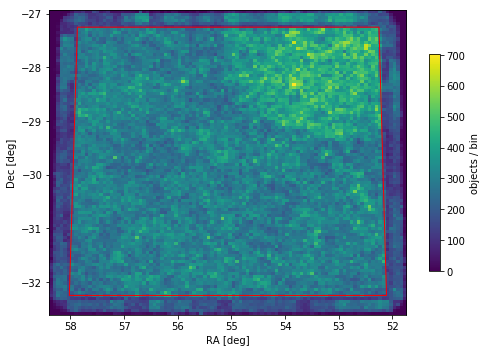

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_aspect(1)

plt.hist2d(df['ra'], df['dec'], bins=100)
plt.xlim(plt.xlim()[::-1])  # Flip to East left
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(shrink=0.5, label='objects / bin')

region = Polygon(dc2_run1x_region, color='red', fill=False)
ax.add_patch(region);

In [12]:
# Select good detections:
#  1. Marked as 'good' in catalog flags.
#  2. SNR in given band > threshold
#  3. In defined simulation range
snr_threshold = 5
snr_filter = 'i'
snr = df['psFlux_%s' % snr_filter] / df['psFluxErr_%s' % snr_filter]

In [13]:
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.

    Parameters
    ----------
    I_xx : float or numpy.array
    I_xy : float or numpy.array
    I_yy : float or numpy.array

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*SM.sqrt(I_xx*I_yy - I_xy*2))
    e1 = np.real(e)
    e2 = np.imag(e)
    return e, e1, e2

In [14]:
for filt in filters:
    df['e_{}'.format(filt)], df['e1_{}'.format(filt)], df['e2_{}'.format(filt)] = \
    ellipticity(df['Ixx_{}'.format(filt)], df['Ixy_{}'.format(filt)], df['Iyy_{}'.format(filt)])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


In [15]:
def inside_trapezoid(corners, ra, dec):
    # This is a slightly tedious way of defining a symmetric trapezoid
    # Could consider using geopandas, but that adds dependency
    dec_size = corners[1][1] - corners[2][1] # deg

    ra_left_side_delta = corners[1][0] - corners[2][0]
    ra_right_side_delta = corners[0][0] - corners[3][0]
    ra_left_side_slope = ra_left_side_delta / dec_size
    ra_right_side_slope = ra_right_side_delta / dec_size

    inside_ra = (corners[2][0] + ra_left_side_slope * (df['dec'] - corners[2][1]) < df['ra']) & \
                (df['ra'] < corners[3][0] + ra_right_side_slope * (df['dec'] - corners[3][1]))
    inside_dec = (corners[2][1] < df['dec']) & (df['dec'] < corners[1][1])
    return inside_ra & inside_dec

In [16]:
inside = inside_trapezoid(dc2_run1x_region, df['ra'], df['dec'])
good = df[(df['good']) & (snr > snr_threshold) & inside]

In [17]:
stars = good[good['extendedness'] == 0]
galaxies = good[good['extendedness'] > 0]

In [18]:
print(len(df), len(good), len(stars), len(galaxies))

2840487 1404230 325781 1073506


In [19]:
print(len(df), len(good), len(stars), len(galaxies))

2840487 1404230 325781 1073506


In [20]:
def plot_ra_dec(cat):
    """We're just doing this on a rectilearn grid.
    We should do a projection, of course, but that distortion is minor in this space."""
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect(1)

    plt.hist2d(cat['ra'], cat['dec'], bins=100)
    plt.xlim(plt.xlim()[::-1])  # Flip to East left
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar(shrink=0.5, label='objects / bin')

    region = Polygon(dc2_run1x_region, color='red', fill=False)
    ax.add_patch(region);

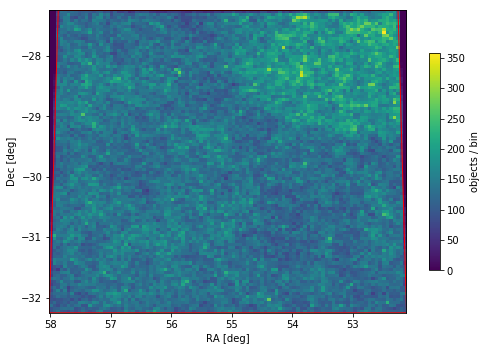

In [21]:
plot_ra_dec(good)

## Color-Color Diagrams and the Stellar Locus

In [22]:
def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile='assets/Davenport_2014_MNRAS_440_3430_table1.txt'):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]
    
    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5,
                       ax=None):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    if not ax:
        ax = fig.gca()

    ax.plot(model_gmr, model_rmi, **plot_kwargs)

In [23]:
def plot_color_color(z, color1, color2, 
                     range1=(-1, +2), range2=(-1, +2), bins=31,
                     ax=None, figsize=(4,4)):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['mag_%s' % band1] - z['mag_%s' % band2],
        z['mag_%s' % band3] - z['mag_%s' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    if not ax:
        fig = plt.figure(figsize=figsize)
        ax = fig.gca()

    ax.pcolormesh(xi, yi, zi, cmap=cmap)
    ax.contour(xi, yi, zi)
    ax.set_xlabel('%s-%s' % (band1, band2))
    ax.set_ylabel('%s-%s' % (band3, band4))

    try:
        plot_stellar_locus(color1, color2, ax=ax)
    except KeyError as e:
        print("Couldn't plot Stellar Locus model for %s, %s" % (color1, color2))

In [24]:
def plot_four_color_color(cat):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    colors = ['umg', 'rmi', 'imz', 'zmy']
    ref_color = 'gmr'
    for ax, color in zip(axes.flat, colors):
        plot_color_color(cat, ref_color, color, ax=ax)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


Couldn't plot Stellar Locus model for gmr, zmy


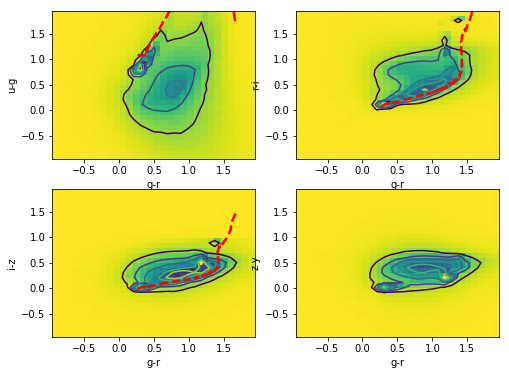

In [25]:
plot_four_color_color(good)

Couldn't plot Stellar Locus model for gmr, zmy


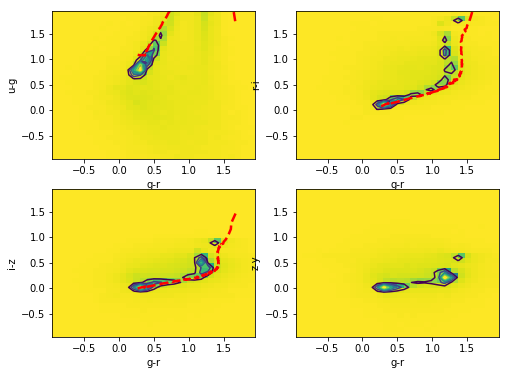

In [26]:
plot_four_color_color(stars)

Couldn't plot Stellar Locus model for gmr, zmy


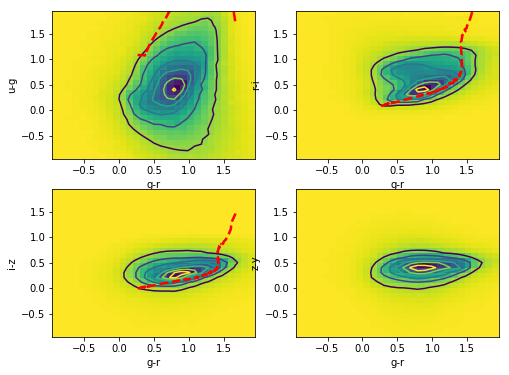

In [27]:
plot_four_color_color(galaxies)

Clearly one doesn't expect the galaxies to follow the stellar locus.  The lines above are include to more easily guide the ey between the stars-only and the galaxies-only plots.

## 1D Density Plots

In [28]:
def plot_mag(filt, ax=None):
    if ax is None:
        ax = fig.gca()
    mag = 'mag_%s' % filt
    ax.hist([good[mag], stars[mag], galaxies[mag]],
             label=['all', 'star', 'galaxy'],
             range=(16, 30),
             bins=np.linspace(16, 30, 100),
             histtype='step')
    ax.set_xlabel(filt)
    ax.set_ylabel('objects / bin')
    ax.legend(loc='upper left')

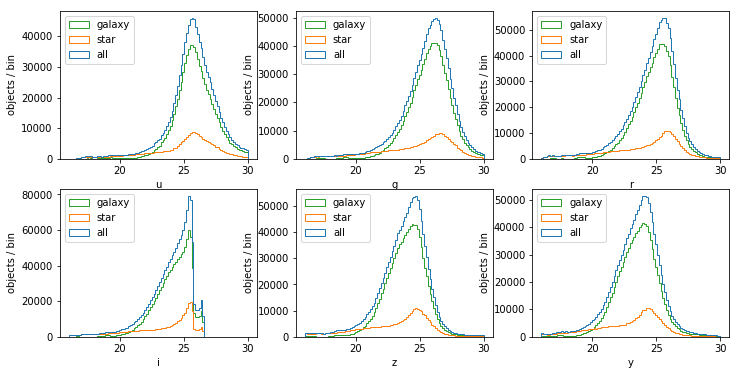

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    plot_mag(filt, ax=ax)

The sharp cut in i-band is because that was the reference band for most detections.  It was r then i.  The u-band points extend to 30th because most of them are non-detections.

But hmmm... what is the extra extended shelf in the i-band histogram from?
Let's select those points and plot them in space and color.

In [30]:
mag_threshold = 26.5
faint_bump_rows = good['mag_i'] > mag_threshold
faint_bump = good[faint_bump_rows]

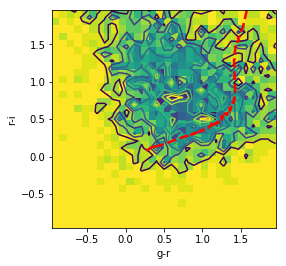

In [31]:
plot_color_color(faint_bump, 'gmr', 'rmi')

(-32.3, -27.2)

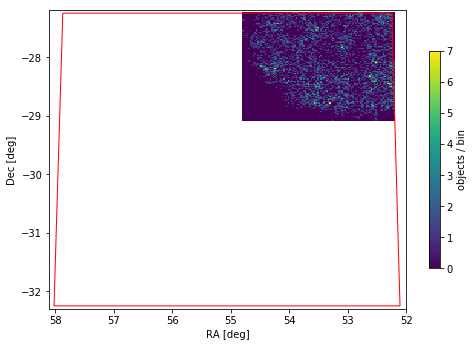

In [32]:
plot_ra_dec(faint_bump)
plt.xlim(58.1, 52.0)
plt.ylim(-32.3, -27.2)

Hmmm... so they're from something in the UDF fields of view.  Naively this region could just be a bit deeper, but the color-color distribution doesn't make any sense.

## Blendedness and Extendedness

In [33]:
w, = np.where(np.isfinite(good['blendedness']))

In [34]:
print(len(good['blendedness']))
print(len(w))

1404230
1352101


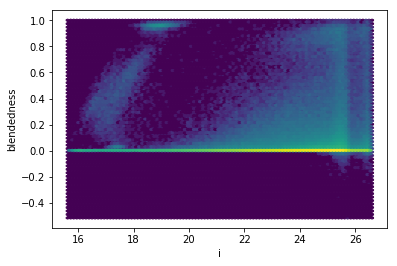

In [35]:
good_blendedness = good[np.isfinite(good['blendedness'])]
plt.hexbin(good_blendedness['mag_i'], good_blendedness['blendedness'],
          bins='log');
plt.xlabel('i')
plt.ylabel('blendedness');

(-0.1, 1.1)

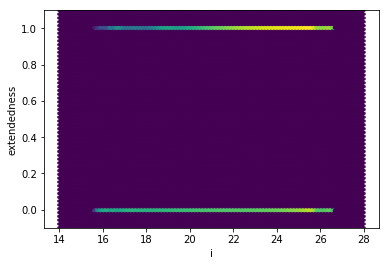

In [36]:
plt.hexbin(good['mag_i'], good['extendedness'],
           extent=(14, 28, -0.1, +1.1),
           bins='log');
plt.xlabel('i')
plt.ylabel('extendedness');
plt.ylim(-0.1, 1.1)

## Shape Parameters
Ixx, Iyy, Ixy

In [37]:
def plot_shape(filt, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['all', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 50),
             'histtype': 'step'}
    for prefix, ls in (('Ixx', '-'), ('Iyy', '--'), ('Ixy', ':')):
        field = '{}_{}'.format(prefix, filt)
        labels = ['{} {}'.format(prefix, name) for name in names]
        ax.hist([good[field], stars[field], galaxies[field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_ylim(100, ax.get_ylim()[1])
    
    ax.set_xlabel('{}-band Moments: Ixx, Iyy, Ixy [pixels^2]'.format(filt))
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

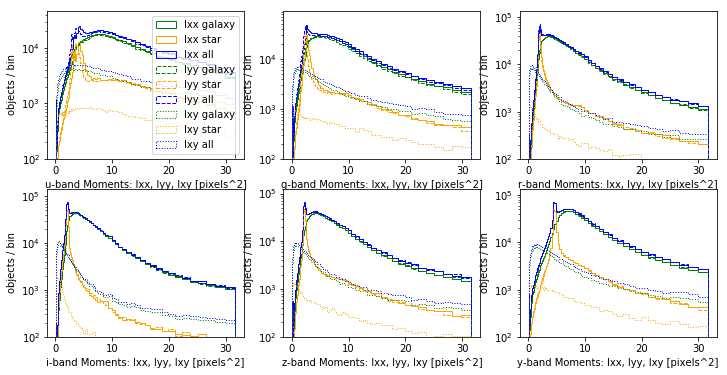

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_shape(filt, ax=ax, legend=legend)
    legend = False

The stars (orange) are concentrated at low values of the source moments.

Would be interesting to
1. Look by magnitude or SNR to undersatnd the longer tail.  Are these galaxies mis-classified as stars, or are these noise sources?
2. Distribution of ellipticity (see validate_drp to type this right)

In [39]:
def plot_ellipticity(good, stars, galaxies, filt, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['all', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 5),
             'histtype': 'step'}
    for prefix, ls in (('e', '-'), ('e1', '--'), ('e2', ':')):
        field = '{}_{}'.format(prefix, filt)
        labels = ['{} {}'.format(prefix, name) for name in names]
        ax.hist([good[field], stars[field], galaxies[field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_xlim(0, 20)
    ax.set_ylim(10, ax.get_ylim()[1])
    
    ax.set_xlabel('{}-band ellipticity'.format(filt))
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

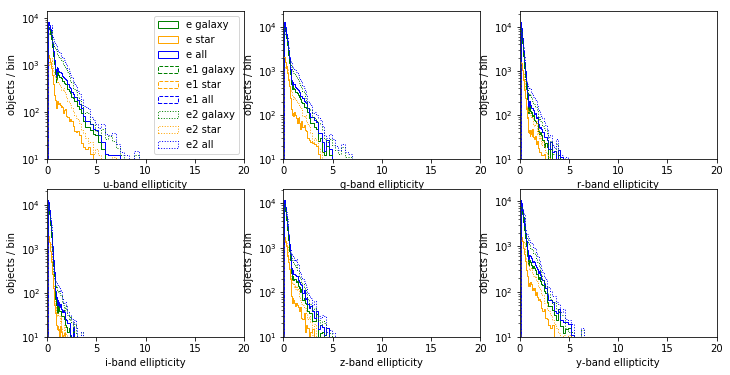

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_ellipticity(good, stars, galaxies, filt, ax=ax, legend=legend)
    legend = False

## FWHM

In [41]:
def plot_psf_fwhm(filters=filters,
                 colors=('purple', 'blue', 'green', 'orange', 'red', 'brown')):
    for filt, color in zip(filters, colors):
        psf_fwhm = np.array(good['psf_fwhm_%s' % filt])
        w, = np.where(np.isfinite(psf_fwhm))
        sns.distplot(psf_fwhm[w], label=filt, color=color)
    plt.xlabel('PSF FWHM [arcsec]')
    plt.ylabel('objects density / bin')
    plt.legend()

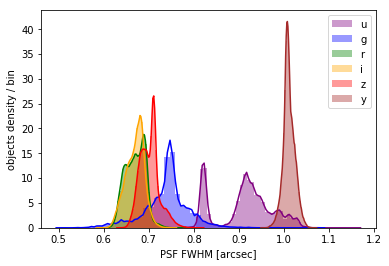

In [42]:
plot_psf_fwhm()